# Bone age prediction of hand radiographs using Neural Networks

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
import time

import matplotlib as mpl
# setting some matplotlib parameters for plots
mpl.rcParams['figure.figsize'] = (15, 15)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams.update({'font.size': 22})


%matplotlib inline
np.random.seed(1)

IMG_SIZE = 224
batch_size = 32
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 1)

In [3]:
cmap = mpl.cm.get_cmap('viridis')
colors = [cmap(0.0), cmap(0.14), cmap(0.28), cmap(0.42), cmap(0.56), cmap(0.7), cmap(0.84)]

## Retrieve datasets

In [4]:
import os
import zipfile

# Define the data folder location
path = '/content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/'
data_dirs = ['Bone Age Training Set', 'Bone Age Validation Set','Bone Age Test Set']
train_dirs = ['boneage-training-dataset', 'dataset_data_file_training-gt-6aaa9791-5bdc-4c6d-9ee9-5a3780a37103']
val_dirs = ['boneage-validation-dataset-1', 'boneage-validation-dataset-2']

train_path = path + 'data/Bone Age Training Set/'
val_path = path + 'data/Bone Age Validation Set/'
test_path = path + 'data/Bone Age Test Set/'
masks_path = path + 'all_training_masks/'
masked_path = path + 'boneage-training-dataset-masked/'

In [5]:
with zipfile.ZipFile(train_path + 'boneage-training-dataset-masked2.zip', 'r') as f:
  f.extractall('.')

In [6]:
!cp -r '/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/data/Bone Age Validation Set/boneage-validation-dataset-masked2' 'boneage-validation-dataset-masked2'

In [7]:
!cp -r '/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/data/Bone Age Test Set/boneage-test-dataset-masked2' 'boneage-test-dataset-masked2'

In [8]:
# # Extract data from zip file
# for data_dir in data_dirs:
#   if not os.path.exists(data_dir):
#   # if not os.path.exists(path + 'data/' + data_dir):
#     with zipfile.ZipFile(path + data_dir + '.zip', 'r') as f:
#       f.extractall('.')
#       # f.extractall(path + 'data')
#   if 'Training' in data_dir: # training set has two more zip files
#     for train_dir in train_dirs:
#       if not os.path.exists(train_dir):
#         with zipfile.ZipFile(data_dir + '/' + train_dir + '.zip', 'r') as f:
#           f.extractall('.')
#       # if not os.path.exists(path + 'data/' + data_dir + '/' + train_dir):
#       #   with zipfile.ZipFile(path + 'data/' + data_dir + '/' + train_dir + '.zip', 'r') as f:
#       #     f.extract(path + data_dir)
#   if 'Validation' in data_dir: # validation set is divided in two more zip files
#     for val_dir in val_dirs:
#       if not os.path.exists(val_dir):
#         with zipfile.ZipFile(data_dir + '/' + val_dir + '.zip', 'r') as f:
#           f.extractall('.')
#       # if not os.path.exists(path + 'data/' + data_dir + '/' + val_dir):
#       #   with zipfile.ZipFile(path + 'data/' + data_dir + '/' + val_dir + '.zip', 'r') as f:
#       #     f.extractall(path + 'data/' + data_dir)

## Creating dataframes

In [9]:
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/utils.py" utils.py
from utils import *

train_df = load_filenames(train_path + 'train.csv', train_path + train_dirs[0])
validation_df = load_filenames(val_path + '/Validation Dataset.csv', val_path + val_dirs[0], val_path + val_dirs[1])
test_df = load_filenames(test_path + '/Bone age ground truth.xlsx', test_path + 'Bone Age Test Set/Test Set Images')

# normalize boneage value to accelerate training
mean_bone_age = train_df['boneage'].mean()
std_bone_age = train_df['boneage'].std()
train_df['boneage_n'] = (train_df['boneage'] - mean_bone_age) / std_bone_age
validation_df['boneage_n'] = (validation_df['boneage'] - mean_bone_age) / std_bone_age
test_df['boneage_n'] = (test_df['boneage'] - mean_bone_age) / std_bone_age

# number of steps between epochs
train_steps = int(np.ceil(train_df.shape[0] / batch_size))
val_steps = int(np.ceil(validation_df.shape[0] / batch_size))

In [10]:
display(train_df.head(3))
display(validation_df.head(3))
display(test_df.head(3))

,image,gender(M/F),boneage,boneage_n
0,/content/drive/My Drive/Colab Notebooks/Human ...,0,180,1.279181
1,/content/drive/My Drive/Colab Notebooks/Human ...,0,12,-2.800269
2,/content/drive/My Drive/Colab Notebooks/Human ...,0,94,-0.809109


,image,gender(M/F),boneage,boneage_n
0,/content/drive/My Drive/Colab Notebooks/Human ...,0,30,-2.363185
1,/content/drive/My Drive/Colab Notebooks/Human ...,1,162,0.842097
2,/content/drive/My Drive/Colab Notebooks/Human ...,0,18,-2.654575


,image,gender(M/F),boneage,boneage_n
0,/content/drive/My Drive/Colab Notebooks/Human ...,1,168.934249,1.010477
1,/content/drive/My Drive/Colab Notebooks/Human ...,1,169.652678,1.027922
2,/content/drive/My Drive/Colab Notebooks/Human ...,1,73.256112,-1.312821


## Preprocessing

### contrast enhancement and normalization

In [11]:
# def ce_norm(df, new_path, factor=2.5):
#   func = lambda p: tf.keras.preprocessing.image.save_img(new_path + p.split('/')[-1], 
#                                                          image_contrast_enhancement(normalize_values(cv2.imread(p)), factor=factor))
#   df['image'].apply(func)
#   df['image'] = df['image'].map(lambda p: new_path + p.split('/')[-1])

# ce_norm(train_df, train_path + 'Train Set Images Contrast/')
# ce_norm(validation_df, val_path + 'Validation Set Images Contrast/', factor=1.5)
# ce_norm(test_df, test_path + 'Test Set Images Contrast/')

### apply masks

In [12]:
# mask_model = tf.keras.models.load_model(path + 'Unet100epochs_trainable={}_contrast.h5'.format('True'), compile=False)

In [13]:
# def apply_masking(df, batch_size, path):
#   original_names = df['image']
#   load_img = lambda file_name : (file_name.split('/')[-1], normalize_values(load_hand_image(file_name, IMG_SIZE)))
#   original_imgs = original_names.map(load_img)
#   for elem in original_imgs:
#     name, img = elem
#     pred = mask_model.predict(np.repeat(np.expand_dims(img, axis=0), batch_size, axis=0))
#     tf.keras.preprocessing.image.save_img(path + name, pred[0])

# apply_masking(validation_df, batch_size, "val_masks/")
# apply_masking(test_df, batch_size, "test_masks/")

In [14]:
# apply_masks(train_df, masks_path, IMG_SIZE, train_df.shape[0], masked_path)
# apply_masks(validation_df, val_path + 'val_masks/', IMG_SIZE, validation_df.shape[0], val_path + 'boneage-validation-dataset-masked/')
# apply_masks(test_df, test_path + 'test_masks/', IMG_SIZE, test_df.shape[0], test_path + 'boneage-test-dataset-masked/')

In [15]:
train_df['image'] = train_df['image'].map(lambda p: 'boneage-training-dataset-masked/' + p.split('/')[-1])
validation_df['image'] = validation_df['image'].map(lambda p: 'boneage-validation-dataset-masked/' + p.split('/')[-1])
test_df['image'] = test_df['image'].map(lambda p: 'boneage-test-dataset-masked/' + p.split('/')[-1])

Visualize mask results

In [16]:
# fig, axs = plt.subplots(3, 3, figsize=(7, 8))
# [ax.axis('off') for ax in axs.flatten()]

# indexes = np.random.randint(0, train_df.shape[0], size=3)
# for ind, (ax1, ax2, ax3) in zip(indexes, axs):
#   name = train_df.loc[ind, 'image'].split('/')[-1]
#   original = cv2.imread(train_path + train_dirs[0] + '/' + name)
#   mask = cv2.imread(path + 'all_training_masks/' + name)
#   masked = cv2.imread(train_df.loc[ind, 'image'])

#   ax1.imshow(original)
#   ax2.imshow(mask)
#   ax3.imshow(masked)

# plt.tight_layout()

In [17]:
# fig, axs = plt.subplots(3, 3, figsize=(7, 8))
# [ax.axis('off') for ax in axs.flatten()]

# indexes = np.random.randint(0, test_df.shape[0], size=3)
# for ind, (ax1, ax2, ax3) in zip(indexes, axs):
#   name = test_df.loc[ind, 'image'].split('/')[-1]
#   original = cv2.imread(test_path + 'Test Set Images/' + name)
#   mask = cv2.imread(test_path + 'test_masks/' + name)
#   masked = cv2.imread(test_df.loc[ind, 'image'])

#   ax1.imshow(original)
#   ax2.imshow(mask)
#   ax3.imshow(masked)

# plt.tight_layout()

### With CLAHE

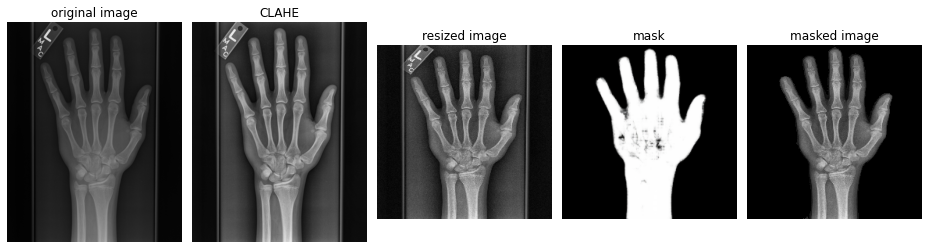

In [18]:
fig, axs = plt.subplots(1, 5, figsize=(13, 17))
[ax.axis('off') for ax in axs.flatten()]

ind = 9
name = test_df.loc[ind, 'image'].split('/')[-1]
original = cv2.imread(test_path + 'Test Set Images/' + name)
clahe = cv2.imread(test_path + 'test_contrast/' + name)
resize = cv2.resize(clahe, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
mask_clahe = cv2.imread(test_path + 'test_masks2/' + name)
masked_clahe = cv2.imread('boneage-test-dataset-masked2/' + name)

imgs = [original, clahe, resize, mask_clahe, masked_clahe]
titles = ['original image', 'CLAHE', 'resized image', 'mask', 'masked image']

for i, ax in enumerate(axs.flatten()):
  ax.imshow(imgs[i])
  ax.set_title(titles[i])
  
plt.tight_layout()

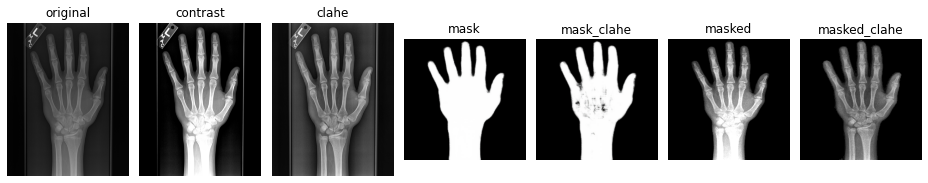

In [19]:
fig, axs = plt.subplots(1, 7, figsize=(13, 17))
[ax.axis('off') for ax in axs.flatten()]

# ind = np.random.randint(0, test_df.shape[0])
ind = 9
name = test_df.loc[ind, 'image'].split('/')[-1]
original = cv2.imread(test_path + 'Test Set Images/' + name)
contrast = cv2.imread(test_path + 'Test Set Images Contrast/' + name)
clahe = cv2.imread(test_path + 'test_contrast/' + name)
mask = cv2.imread(test_path + 'test_masks/' + name)
mask_clahe = cv2.imread(test_path + 'test_masks2/' + name)
masked = cv2.imread(test_path + test_df.loc[ind, 'image'])
masked_clahe = cv2.imread('boneage-test-dataset-masked2/' + name)

imgs = [original, contrast, clahe, mask, mask_clahe, masked, masked_clahe]
titles = ['original', 'contrast', 'clahe', 'mask', 'mask_clahe', 'masked', 'masked_clahe']

for i, ax in enumerate(axs.flatten()):
  ax.imshow(imgs[i])
  ax.set_title(titles[i])
  
plt.tight_layout()

In [20]:
train_df['image'] = train_df['image'].apply(lambda p: 'boneage-training-dataset-masked2/'+ p.split('/')[-1])
validation_df['image'] = validation_df['image'].apply(lambda p: 'boneage-validation-dataset-masked2/'+ p.split('/')[-1])
test_df['image'] = test_df['image'].apply(lambda p: 'boneage-test-dataset-masked2/'+ p.split('/')[-1])

## Data augmentation, Batching, Normalization

In [34]:
datagen_train = ImageDataGenerator(preprocessing_function=lambda x: x/255.,
                                   zoom_range=0.2, rotation_range=25, 
                                   width_shift_range=0.25, height_shift_range=0.25, 
                                   horizontal_flip=True, shear_range = 0.2)
datagen_val = ImageDataGenerator(preprocessing_function=lambda x: x/255., width_shift_range=0.25, 
                                 height_shift_range=0.25, horizontal_flip=True)
datagen_test = ImageDataGenerator(preprocessing_function=lambda x: x/255.)

train_gen = gen_2inputs(datagen_train, train_df, IMG_SIZE, batch_size, shuffle=True, seed=1)
val_gen = gen_2inputs(datagen_val, validation_df, IMG_SIZE, batch_size, shuffle=True, seed=1)
test_gen = gen_2inputs(datagen_test, test_df, IMG_SIZE, test_df.shape[0])

## Models for prediction

In [22]:
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/models.py" models.py
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/inc_v4.py" inc_v4.py
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/res_net.py" res_net.py
from models import *

epochs = 50

We use the mean absolute error as metric, as suggested in the papers

In [23]:
from keras.metrics import mean_absolute_error
def mae_in_months(x, y):
    """
    Return mean absolute error in months

    Arguments:
    x -- predicted value
    y -- ground-truth
    """
    mean_bone_age = train_df['boneage'].mean()
    std_bone_age = train_df['boneage'].std()
    return mean_absolute_error((std_bone_age*x + mean_bone_age), (std_bone_age*y + mean_bone_age)) 

Create the callbacks for the fit function

In [24]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=1, mode='auto',
                                min_delta=0.0001, cooldown=5, min_lr=0.0000001)

In [25]:
from keras.callbacks import Callback

class CustomCallback(Callback):
    def __init__(self):
        self.timeref = time.time()
        self.loss = []
        self.val_loss = []
    def on_epoch_end(self, epoch,logs = {}):
        logs['train_time'] = time.time() - self.timeref
        self.loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
    def on_train_end(self, logs = {}):
        plt.figure(figsize=(10, 5))
        plt.yscale('log')
        plt.plot(range(len(self.loss)), self.loss, label='Training loss')
        plt.plot(range(len(self.loss)), self.val_loss, label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss Value')
        plt.legend()
        plt.show()

### First place solution

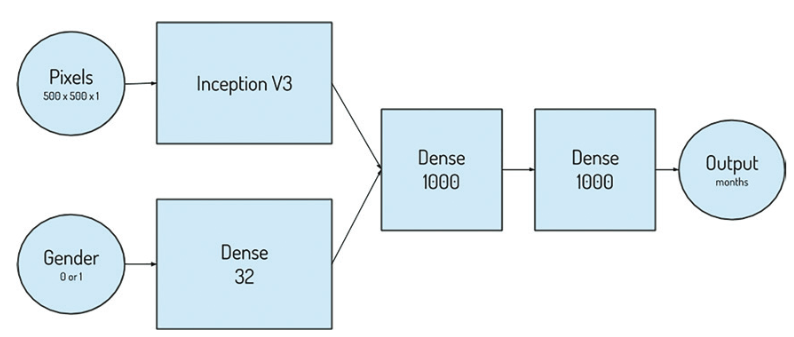

In [ ]:
model_name = 'incV3'
gender = True
weight_path = path + 'models_checkpoints/'+ "incV3-04-02_weights.best.hdf5"
incV3_model = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)
# tf.keras.utils.plot_model(incV3_model, show_shapes=True, dpi=64)

In [ ]:
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
csv_logger = CSVLogger('/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/training_incV3_04-02.log', append=True)
callbacks = [checkpoint, reduce_lr, CustomCallback(), csv_logger]

incV3_history, incV3_time = fit_boneage(incV3_model, train_gen, train_steps, val_gen, val_steps,
                                        epochs, callbacks, gender)

In [ ]:
# load the best version of the model
incV3_model.load_weights(weight_path)

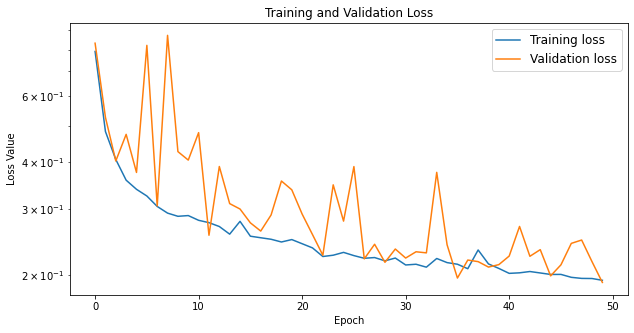

In [ ]:
incV3_logs = pd.read_csv(path + 'training_incV3_28-01.log')

plt.figure(figsize=(10, 5))
plt.yscale('log')
plt.plot(range(incV3_logs.shape[0]), incV3_logs['loss'], label='Training loss')
plt.plot(range(incV3_logs.shape[0]), incV3_logs['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

### InceptionV4
In this case we took the first-place solution replacing the Inception V3 model with an Inception V4, with the result of concatenating the 32-dimension vector corresponding to the gender with the pixels' vector of 75,264 dimensions (instead of 100,352)

In [ ]:
model_name = 'incV4'
gender = True
weight_path = path + 'models_checkpoints/'+ "{}-01-02_weights.best.hdf5".format(model_name)
incV4_model = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)

In [ ]:
tf.keras.utils.plot_model(incV4_model, show_shapes=True, dpi=64)

Found 12611 validated image filenames.
Found 12611 validated image filenames.
Epoch 1/50
395/395 [==============================] - ETA: 0s - loss: 0.8448 - mae_in_months: 34.7899Found 1425 validated image filenames.
Found 1425 validated image filenames.

Epoch 1: val_loss improved from inf to 0.86431, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpoints/incV4-01-02_weights.best.hdf5
395/395 [==============================] - 272s 614ms/step - loss: 0.8448 - mae_in_months: 34.7899 - val_loss: 0.8643 - val_mae_in_months: 35.5938 - lr: 0.0010 - train_time: 272.6443
Epoch 2/50
395/395 [==============================] - ETA: 0s - loss: 0.7182 - mae_in_months: 29.5783
Epoch 2: val_loss improved from 0.86431 to 0.61092, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpoints/incV4-01-02_weights.best.hdf5
395/395 [==============================] - 238s 602ms/step - loss: 0.7182 - mae_in_

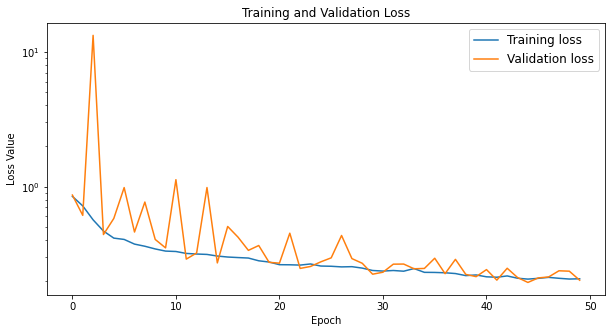

TRAINING FINISHED
Training time: 11885.960419178009
Loss: [0.8447847366333008, 0.718232274055481, 0.5658540725708008, 0.46722933650016785, 0.4139617681503296, 0.4047197103500366, 0.3736802339553833, 0.3602272868156433, 0.3439677655696869, 0.3315659761428833, 0.3293047845363617, 0.3185352385044098, 0.3153841197490692, 0.31320780515670776, 0.30467891693115234, 0.2995927929878235, 0.2968601584434509, 0.2944158911705017, 0.28089943528175354, 0.2750314772129059, 0.2627573013305664, 0.2623330354690552, 0.2609844207763672, 0.2660689949989319, 0.25674113631248474, 0.2558026611804962, 0.25306424498558044, 0.2540494203567505, 0.24785658717155457, 0.2379809021949768, 0.23558878898620605, 0.23793207108974457, 0.23508049547672272, 0.24599669873714447, 0.23055312037467957, 0.2302006036043167, 0.22888103127479553, 0.22584198415279388, 0.21799291670322418, 0.22047016024589539, 0.21359938383102417, 0.21204183995723724, 0.21681378781795502, 0.2085096389055252, 0.20536907017230988, 0.20805899798870087, 0

In [ ]:
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
csv_logger = CSVLogger('/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/training_incV4_01-02.log', append=True)
callbacks = [checkpoint, reduce_lr, CustomCallback(), csv_logger]

incV4_history, incV4_time = fit_boneage(incV4_model, train_gen, train_steps, val_gen, val_steps,
                                        epochs, callbacks, gender)

### Simple CNN
Here we used a simple multi-layer convolution network 


In [ ]:
model_name = 'simple_conv'
gender = True
weight_path = path + 'models_checkpoints/'+ "{}-31-01_weights.best.hdf5".format(model_name)
simple_conv_model = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)

395/395 [==============================] - ETA: 0s - loss: 0.7811 - mae_in_months: 32.1662
Epoch 1: val_loss improved from inf to 0.77388, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpoints/simple_conv_weights.best.hdf5
395/395 [==============================] - 882s 2s/step - loss: 0.7811 - mae_in_months: 32.1662 - val_loss: 0.7739 - val_mae_in_months: 31.8698 - lr: 0.0010


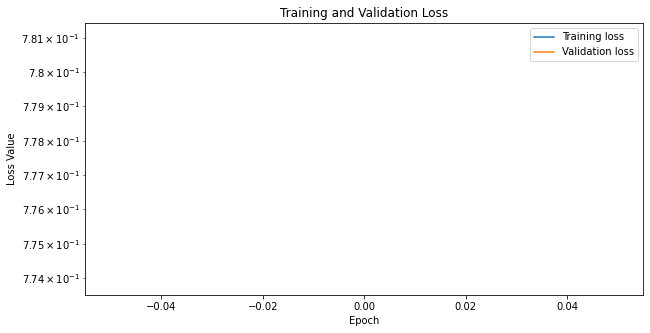

TRAINING FINISHED
Training time: 924.664466381073
Loss: [0.7810739278793335]
MAE in months: [32.16621398925781]
Parameters: 87655737


<Figure size 432x288 with 0 Axes>

In [ ]:
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
csv_logger = CSVLogger('/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/training_cnn_31-01.log', append=True)
callbacks = [checkpoint, reduce_lr, CustomCallback(), csv_logger]

simple_conv_history, simple_conv_time = fit_boneage(simple_conv_model, train_gen, train_steps, val_gen, val_steps,
                                                    epochs, callbacks, gender)

In [ ]:
simple_conv_model.load_weights(weight_path)

### VGG16

In [ ]:
model_name = 'vgg16'
gender = True
weight_path = path + 'models_checkpoints/'+ "VGG16_weights-09-02.best.hdf5"
optim = tf.keras.optimizers.Adam(learning_rate=0.00001)
vgg16_model = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', optim, mae_in_months, with_gender=gender)
# tf.keras.utils.plot_model(vgg16_model, show_shapes=True, dpi=64)

In [ ]:
vgg16_model.load_weights(weight_path)

Found 12611 validated image filenames.
Found 12611 validated image filenames.
Epoch 1/45
  6/395 [..............................] - ETA: 3:08 - loss: 0.7685 - mae_in_months: 31.6499

395/395 [==============================] - ETA: 0s - loss: 0.7547 - mae_in_months: 31.0811Found 1425 validated image filenames.
Found 1425 validated image filenames.

Epoch 1: val_loss improved from inf to 0.75198, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpoints/VGG16_weights-09-02.best.hdf5
395/395 [==============================] - 200s 507ms/step - loss: 0.7547 - mae_in_months: 31.0811 - val_loss: 0.7520 - val_mae_in_months: 30.9680 - lr: 1.0000e-05 - train_time: 200.8022
Epoch 2/45
395/395 [==============================] - ETA: 0s - loss: 0.7451 - mae_in_months: 30.6854
Epoch 2: val_loss did not improve from 0.75198
395/395 [==============================] - 200s 507ms/step - loss: 0.7451 - mae_in_months: 30.6854 - val_loss: 0.7570 - val_mae_in_months: 31.1766 - lr: 1.0000e-05 - train_time: 401.1633
Epoch 3/45
395/395 [==============================] - ETA: 0s - loss: 0.7393 - mae_in_months: 30.4450
Epoch 3: val_loss impr

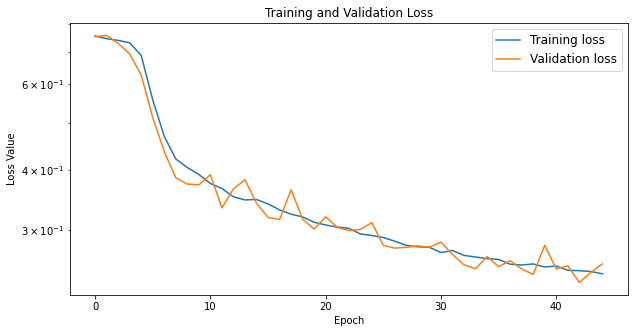

TRAINING FINISHED
Training time: 9163.267607212067
Loss: [0.7547247409820557, 0.7451168894767761, 0.7392780184745789, 0.7307602167129517, 0.6880519986152649, 0.5574197769165039, 0.4687684178352356, 0.42107951641082764, 0.4042738676071167, 0.39131999015808105, 0.37478357553482056, 0.36599990725517273, 0.3518409729003906, 0.34664538502693176, 0.34740492701530457, 0.3401944637298584, 0.33064448833465576, 0.3239280581474304, 0.31981176137924194, 0.3118163049221039, 0.30776742100715637, 0.30471083521842957, 0.3030448257923126, 0.2950562536716461, 0.2927822172641754, 0.29007646441459656, 0.28493908047676086, 0.27942904829978943, 0.2775404751300812, 0.2768193185329437, 0.2701059877872467, 0.27262112498283386, 0.2664501965045929, 0.26439327001571655, 0.26235637068748474, 0.2613445818424225, 0.2555557191371918, 0.2545565366744995, 0.25578969717025757, 0.2521604597568512, 0.25326213240623474, 0.24820125102996826, 0.2477685511112213, 0.2468346655368805, 0.2441050112247467]
MAE in months: [31.0810

In [ ]:
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
csv_logger = CSVLogger('/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/training_VGG16_09-02.log', append=True)
callbacks = [checkpoint, reduce_lr, CustomCallback(), csv_logger]

vgg16_history, vgg16_time = fit_boneage(vgg16_model, train_gen, train_steps, val_gen, val_steps,
                                        epochs, callbacks, gender)

### ResNet50

In [ ]:
from res_net import *
model_name = 'resnet50'
gender = True
weight_path = path + 'models_checkpoints/'+ "{}_weights_31-01.best.hdf5".format(model_name)

optim = tf.keras.optimizers.Adam(learning_rate=0.0001)
resnet_model = create_model(model_name, (IMG_SIZE, IMG_SIZE, 1), 'mean_absolute_error', optim, mae_in_months, with_gender=gender)
# tf.keras.utils.plot_model(resnet_model, show_shapes=True, dpi=64)

In [ ]:
resnet_model.load_weights(weight_path)

In [ ]:
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
csv_logger = CSVLogger('/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/training_resnet_31.log', append=True)
callbacks = [checkpoint, reduce_lr, CustomCallback(), csv_logger]

resnet_history, resnet_time = fit_boneage(resnet_model, train_gen, train_steps, val_gen, val_steps,
                                        epochs, callbacks, gender)

Found 12611 validated image filenames.
Found 12611 validated image filenames.
Epoch 1/50
  6/395 [..............................] - ETA: 2:26 - loss: 5.8319 - mae_in_months: 240.1684

395/395 [==============================] - ETA: 0s - loss: 0.9954 - mae_in_months: 40.9944Found 1425 validated image filenames.
Found 1425 validated image filenames.

Epoch 1: val_loss improved from inf to 0.87532, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpoints/resnet50_weights_31-01.best.hdf5
395/395 [==============================] - 176s 431ms/step - loss: 0.9954 - mae_in_months: 40.9944 - val_loss: 0.8753 - val_mae_in_months: 36.0473 - lr: 1.0000e-04 - train_time: 175.9460
Epoch 2/50
395/395 [==============================] - ETA: 0s - loss: 0.8227 - mae_in_months: 33.8813
Epoch 2: val_loss improved from 0.87532 to 0.81801, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpoints/resnet50_weights_31-01.best.hdf5
395/395 [==============================] - 172s 436ms/step - loss: 0.8227 - mae_in_months: 33.8813 - val_loss: 0.8180 - val_mae_in_months: 33.6871 - lr: 1.0000e-0

### Inception-ResNet-v2

In [42]:
from tensorflow.keras import backend
from tensorflow.keras.layers import Lambda

### CONVOLUTIONAL AND BATCHNORM HELPER FUNCTION ###
def conv2d_bn(X_input, filters, kernel_size, strides, padding='same', activation=None,
              name=None):
    """
    Implementation of a conv block as defined above
    
    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    filters -- integer, defining the number of filters in the CONV layer
    kernel_size -- (f1, f2) tuple of integers, specifying the shape of the CONV kernel
    s -- integer, specifying the stride to be used
    padding -- padding approach to be used
    name -- name for the layers
    
    Returns:
    X -- output of the conv2d_bn block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'conv_'
    bn_name_base = 'bn_'

    X = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, 
               padding = padding, name = conv_name_base + name, 
               kernel_initializer = glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(axis = 3, name = bn_name_base + name)(X)
    if activation:
        X = Activation(activation)(X)
    return X


### STEM BLOCK ###
def stem_block(X_input):
    """
    Implementation f the stem block as defined above
    
    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    
    Returns:
    X -- output of the stem block, tensor of shape (n_H, n_W, n_C)
    """
    # First conv 
    X = conv2d_bn(X_input, filters = 32, kernel_size = (3, 3), strides = (2, 2), 
                  padding = 'valid', activation='relu', name = 'stem_1th')
    
    # Second conv
    X = conv2d_bn(X, filters = 32, kernel_size = (3, 3), strides = (1, 1), 
                  padding = 'valid', activation='relu', name = 'stem_2nd')

    # Third conv
    X = conv2d_bn(X, filters = 64, kernel_size = (3, 3), strides = (1, 1), 
                  padding = 'same', activation='relu', name =  'stem_3rd')

    # First branch: max pooling
    branch1 = MaxPooling2D(pool_size = (3, 3), strides = (2, 2),
                           padding = 'valid', name = 'stem_1stbranch_1')(X)

    # Second branch: conv
    branch2 = conv2d_bn(X, filters = 96, kernel_size = (3, 3), 
                        strides = (2, 2), padding = 'valid', activation='relu', 
                        name = 'stem_1stbranch_2')

    # Concatenate (1) branch1 and branch2 along the channel axis
    X = tf.concat(values=[branch1, branch2], axis=3)

    # First branch: 2 convs
    branch1 = conv2d_bn(X, filters = 64, kernel_size = (1, 1), 
                        strides = (1, 1), padding = 'same', activation='relu', 
                        name = 'stem_2ndbranch_1_1') 
    branch1 = conv2d_bn(branch1, filters = 96, kernel_size = (3, 3), 
                        strides = (1, 1), padding = 'valid', activation='relu', 
                        name = 'stem_2ndbranch_1_2') 
    
    # Second branch: 4 convs
    branch2 = conv2d_bn(X, filters = 64, kernel_size = (1, 1), 
                        strides = (1, 1), padding = 'same', activation='relu', 
                        name = 'stem_2ndbranch_2_1') 
    branch2 = conv2d_bn(branch2, filters = 64, kernel_size = (7, 1), 
                        strides = (1, 1), padding = 'same', activation='relu', 
                        name = 'stem_2ndbranch_2_2') 
    branch2 = conv2d_bn(branch2, filters = 64, kernel_size = (1, 7), 
                        strides = (1, 1), padding = 'same', activation='relu', 
                        name = 'stem_2ndbranch_2_3') 
    branch2 = conv2d_bn(branch2, filters = 96, kernel_size = (3, 3), 
                        strides = (1, 1), padding = 'valid', activation='relu', 
                        name = 'stem_2ndbranch_2_4') 

    # Concatenate (2) branch1 and branch2 along the channel axis
    X = tf.concat(values=[branch1, branch2], axis=3)

    # First branch: conv
    branch1 = conv2d_bn(X, filters = 192, kernel_size = (3, 3), 
                        strides = (2, 2), padding = 'valid', activation='relu', 
                        name = 'stem_3rdbranch_1')

    # Second branch: max pooling
    branch2 = MaxPooling2D(pool_size = (3, 3), strides = (2, 2),
                           padding = 'valid', name = 'stem_3rdbranch_2')(X)

    # Concatenate (3) branch1 and branch2 along the channel axis
    X = tf.concat(values=[branch1, branch2], axis=3)
    
    return X

### INCEPTION-A BLOCK ###
def incres_a_block(X_input, base_name):
    """
    Implementation of the Inception-A block
    
    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    
    Returns:
    X -- output of the block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Branch 2
    branch2 = conv2d_bn(X_input, filters = 32, kernel_size = (1, 1), 
                        strides = (1, 1), padding = 'same', activation='relu', 
                        name = base_name + 'ia_branch_2_1')
    
    # Branch 3
    branch3 = conv2d_bn(X_input, filters = 32, kernel_size = (1, 1), 
                        strides = (1, 1), padding = 'same', activation='relu', 
                        name = base_name + 'ia_branch_3_1')
    branch3 = conv2d_bn(branch3, filters = 32, kernel_size = (3, 3), 
                        strides = (1, 1), padding = 'same', activation='relu', 
                        name = base_name + 'ia_branch_3_2')

    # Branch 4
    branch4 = conv2d_bn(X_input, filters = 32, kernel_size = (1, 1), 
                        strides = (1, 1), padding = 'same', activation='relu', 
                        name = base_name + 'ia_branch_4_1')
    branch4 = conv2d_bn(branch4, filters = 32, kernel_size = (3, 3), 
                        strides = (1, 1), padding = 'same', activation='relu', 
                        name = base_name + 'ia_branch_4_2')
    branch4 = conv2d_bn(branch4, filters = 32, kernel_size = (3, 3), 
                        strides = (1, 1), padding = 'same', activation='relu', 
                        name = base_name + 'ia_branch_4_3')

    # Concatenate branch1, branch2, branch3 and branch4 along the channel axis
    X = tf.concat(values=[branch2, branch3, branch4], axis=3)

    # X = conv2d_bn(X, filters = 256, kernel_size = (1, 1), strides = (1, 1), 
    #               padding='same', activation='relu', name = base_name + 'ia_branch_4_4')
    X = conv2d_bn(X, filters = 384, kernel_size = (1, 1), strides = (1, 1), 
                  padding='same', activation='relu', name = base_name + 'ia_branch_4_4')
    
    X = tf.keras.layers.add([X, X_input])
    
    return X


### INCEPTION-B ###
def incres_b_block(X_input, base_name):
    """
    Implementation of the Inception-B block
    
    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    
    Returns:
    X -- output of the block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Branch 2
    branch2 = conv2d_bn(X_input, filters = 128, kernel_size = (1, 1), 
                        strides = (1, 1), padding = 'same', activation='relu', 
                        name = base_name + 'ib_branch_2_1')

    # Branch 4
    branch4 = conv2d_bn(X_input, filters = 128, kernel_size = (1, 1), 
                        strides = (1, 1), padding = 'same', activation='relu', 
                        name = base_name + 'ib_branch_4_1')
    branch4 = conv2d_bn(branch4, filters = 128, kernel_size = (1, 7), 
                        strides = (1, 1), padding = 'same', activation='relu', 
                        name = base_name + 'ib_branch_4_2')
    branch4 = conv2d_bn(branch4, filters = 128, kernel_size = (7, 1), 
                        strides = (1, 1), padding = 'same', activation='relu', 
                        name = base_name + 'ib_branch_4_3')

    # Concatenate branch1, branch2, branch3 and branch4 along the channel axis
    X = tf.concat(values=[branch2, branch4], axis=3)

    # X = conv2d_bn(X, filters = 896, kernel_size = (1, 1), strides = (1, 1), 
    #               padding='same', activation='relu', name = base_name + 'ib_branch_4_6')
    X = conv2d_bn(X, filters = 1152, kernel_size = (1, 1), strides = (1, 1), 
                  padding='same', activation='relu', name = base_name + 'ib_branch_4_6')
    
    X = tf.keras.layers.add([X, X_input])
    
    return X


### INCEPTION-C ###
def incres_c_block(X_input, base_name):
    """
    Implementation of the Inception-C block
    
    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    
    Returns:
    X -- output of the block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Branch 2
    branch2 = conv2d_bn(X_input, filters = 192, kernel_size = (1, 1), 
                        strides = (1, 1), padding = 'same', activation='relu', 
                        name = base_name + 'ic_branch_2_1')

    # Branch 4
    branch4 = conv2d_bn(X_input, filters = 192, kernel_size = (1, 1), 
                        strides = (1, 1), padding = 'same', activation='relu', 
                        name = base_name + 'ic_branch_4_1')
    branch4 = conv2d_bn(branch4, filters = 192, kernel_size = (1, 3), 
                        strides = (1, 1), padding = 'same', activation='relu', 
                        name = base_name + 'ic_branch_4_2')
    branch4 = conv2d_bn(branch4, filters = 192, kernel_size = (3, 1), 
                        strides = (1, 1), padding = 'same', activation='relu', 
                        name = base_name + 'ic_branch_4_3')

    # Concatenate branch1, branch2, branch3_1, branch3_2, branch4_1 and branch4_2 along the channel axis
    X = tf.concat(values=[branch2, branch4], axis=3, name='concat_' + base_name)
    
    # X = conv2d_bn(X, filters = 1792, kernel_size = (1, 1), strides = (1, 1), 
    #               padding='same', activation='relu', name = base_name + 'ic_branch_4_6')
    X = conv2d_bn(X, filters = 2048, kernel_size = (1, 1), strides = (1, 1), 
                  padding='same', activation='relu', name = base_name + 'ic_branch_4_6')
    
    X = tf.keras.layers.add([X, X_input])
    
    return X


### REDUCTION-A ###
def reduction_a_block(X_input):
    """
    Implementation of the Reduction-A block
    
    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    
    Returns:
    X -- output of the block, tensor of shape (n_H, n_W, n_C)
    """

    # Branch 1
    branch1 = MaxPooling2D(pool_size = (3, 3), strides = (2, 2), 
                           padding = 'valid', name = 'ra_branch_1_1')(X_input)
    
    # Branch 2
    branch2 = conv2d_bn(X_input, filters = 384, kernel_size = (3, 3), 
                        strides = (2, 2), padding = 'valid', activation='relu', 
                        name = 'ra_branch_2_1')
    
    # Branch 3
    branch3 = conv2d_bn(X_input, filters = 256, kernel_size = (1, 1), 
                        strides = (1, 1), padding = 'same', activation='relu', 
                        name = 'ra_branch_3_1')
    branch3 = conv2d_bn(branch3, filters = 256, kernel_size = (3, 3), 
                        strides = (1, 1), padding = 'same', activation='relu', 
                        name = 'ra_branch_3_2')
    branch3 = conv2d_bn(branch3, filters = 384, kernel_size = (3, 3), 
                        strides = (2, 2), padding = 'valid', activation='relu', 
                        name = 'ra_branch_3_3')

    # Concatenate branch1, branch2 and branch3 along the channel axis
    X = tf.concat(values=[branch1, branch2, branch3], axis=3)
    
    return X


### REDUCTION-B ###
def reduction_b_block(X_input):
    """
    Implementation of the Reduction-B block
    
    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    
    Returns:
    X -- output of the block, tensor of shape (n_H, n_W, n_C)
    """

    # Branch 1
    branch1 = MaxPooling2D(pool_size = (3, 3), strides = (2, 2), 
                           padding = 'valid', name = 'rb_branch_1_1')(X_input)
    
    # Branch 2
    branch2 = conv2d_bn(X_input, filters = 256, kernel_size = (1, 1), 
                        strides = (1, 1), padding = 'same', activation='relu', 
                        name = 'rb_branch_2_1')
    branch2 = conv2d_bn(branch2, filters = 384, kernel_size = (3, 3), 
                        strides = (2, 2), padding = 'valid', activation='relu', 
                        name = 'rb_branch_2_2')
    
    # Branch 2
    branch4 = conv2d_bn(X_input, filters = 256, kernel_size = (1, 1), 
                        strides = (1, 1), padding = 'same', activation='relu', 
                        name = 'rb_branch_4_1')
    branch4 = conv2d_bn(branch4, filters = 256, kernel_size = (3, 3), 
                        strides = (2, 2), padding = 'valid', activation='relu', 
                        name = 'rb_branch_4_2')
    
    # Branch 3
    branch3 = conv2d_bn(X_input, filters = 256, kernel_size = (1, 1), 
                        strides = (1, 1), padding = 'same', activation='relu', 
                        name = 'rb_branch_3_1')
    branch3 = conv2d_bn(branch3, filters = 256, kernel_size = (3, 3), 
                        strides = (1, 1), padding = 'same', activation='relu', 
                        name = 'rb_branch_3_2')
    branch3 = conv2d_bn(branch3, filters = 256, kernel_size = (3, 3), 
                        strides = (2, 2), padding = 'valid', activation='relu', 
                        name = 'rb_branch_3_4')

    # Concatenate branch1, branch2 and branch3 along the channel axis
    X = tf.concat(values=[branch1, branch2, branch3, branch4], axis=3)
    
    return X


### InceptionResNetV2 COMPOSITION ###
def InceptionResNetV2(X_input, include_top=True):
    """
    Implementation of the InceptionResNetV2 architecture

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    X -- output of the InceptionResNetV2 block
    """

    # X_input = Input(input_shape)

    # Stem block
    X = stem_block(X_input)

    # Four Inception A blocks
    X = incres_a_block(X, 'a1')
    X = incres_a_block(X, 'a2')
    X = incres_a_block(X, 'a3')
    X = incres_a_block(X, 'a4')

    # Reduction A block
    X = reduction_a_block(X)

    # Seven Inception B blocks
    X = incres_b_block(X, 'b1')
    X = incres_b_block(X, 'b2')
    X = incres_b_block(X, 'b3')
    X = incres_b_block(X, 'b4')
    X = incres_b_block(X, 'b5')
    X = incres_b_block(X, 'b6')
    X = incres_b_block(X, 'b7')

    # Reduction B block
    X = reduction_b_block(X)

    # Three Inception C blocks
    X = incres_c_block(X, 'c1')
    X = incres_c_block(X, 'c2')
    X = incres_c_block(X, 'c3')

    # Final pooling and prediction 
    if include_top:
        # AvgPool
        kernel_pooling = X.get_shape()[1:3]
        X = AveragePooling2D(kernel_pooling, name='avg_pool')(X)
        X = Flatten()(X)

        # Dropout
        X = Dropout(rate = 0.2)(X)

        # Output layer
        X = Dense(1, activation='softmax', name='fc')(X)
    
    return X

    # # Create model
    # model = Model(inputs = X_input, outputs = X, name='Inceptionv4')

    # return model

In [43]:
def create_model(model_name, img_shape, loss, optim, metric, with_gender=True):
    """
    Implementation of an architecture for bone age prediction with different backbone models
    
    Arguments:
    model_name -- name of the chosen backbone model
    img_shape -- shape of the images of the dataset
    loss -- loss with which to compile the model
    optim -- optimizer with which to compile the model
    metric -- metric with which to compile the model
    with_gender -- if False, gender data is not used in the model
    
    Returns:
    Model() instance in Keras
    """

    X_input = Input(shape=img_shape)
    gen_input = Input(shape=(1,))

    # choose backbone
    if model_name == 'incV3':
        # Inception block (image data)    
        inc_model = InceptionV3(input_tensor=X_input, input_shape=img_shape, include_top=False, weights=None)
        inc_model.trainable=True
        X = inc_model.get_layer('mixed10').output # 14 x 14 x 2048
        X = AveragePooling2D((2, 2))(X) # 7 x 7 x 2048

    if model_name == 'incV4':
        # Inception block (image data)
        X = Inceptionv4(X_input, include_top=False) # 14 x 14 x 1536
        X = AveragePooling2D((2, 2))(X) # 7 x 7 x 1536

    if model_name == 'simple_conv':
        # Convolutional block (image data)
        X = Conv2D(32, (3,3), activation='relu')(X_input)
        X = MaxPooling2D((2, 2))(X)
        X = Conv2D(64, (3,3), activation='relu')(X)
        X = MaxPooling2D((2, 2))(X)
        X = Conv2D(128, (3,3), activation='relu')(X)
        X = MaxPooling2D((2, 2))(X)

    if model_name == 'vgg16':
        # VGG16 block (image data)
        vgg16_model = VGG16(input_tensor=X_input, include_top=False, weights=None)
        vgg16_model.trainable = True
        X = vgg16_model.get_layer('block5_conv3').output
        X = AveragePooling2D((2, 2))(X)

    if model_name == 'resnet50':
        # ResNet50 block
        res_net = ResNet50(input_tensor=X_input, include_top=False)
        res_net.trainable = True
        X = res_net.layers[-1].get_output_at(0)

    if model_name == 'incRes':
        # Inception block (image data)
        X = InceptionResNetV2(X_input, include_top=False)
        # incres = tf.keras.applications.InceptionResNetV2(input_tensor=X_input, include_top=False, weights=None)
        # X = incres.layers[-1].get_output_at(0)
        X = AveragePooling2D((2, 2))(X)

    # common structure after backbone
    X = Flatten()(X)

    if with_gender:
        # Dense block (gender data)
        gen = Dense(32, activation='relu')(gen_input)

        # Concatenation of image and gender data
        X = tf.concat(values=[X, gen], axis=1)

    # First Dense block
    X = Dense(1000, activation='relu')(X)

    # Second Dense block
    X = Dense(1000, activation='relu')(X)

    # Fully connected layer
    X = Dense(1)(X)

    model = tf.keras.Model(inputs=[X_input, gen_input], outputs=X, name=model_name)
    model.compile(loss=loss, optimizer=optim, metrics=[metric])

    return model

In [ ]:
model_name = 'incRes'
gender = True
weight_path = path + 'models_checkpoints/'+ "{}_weights_09-02.best.hdf5".format(model_name)

optim = tf.keras.optimizers.Adam(learning_rate=0.01)
incRes = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)
# tf.keras.utils.plot_model(incRes, show_shapes=True, dpi=64)

In [ ]:
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
csv_logger = CSVLogger('/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/training_incRes_09-02.log', append=True)
callbacks = [checkpoint, reduce_lr, CustomCallback(), csv_logger]

incRes_history, incRes_time = fit_boneage(incRes, train_gen, train_steps, val_gen, val_steps,
                                        epochs, callbacks, True)

Found 12611 validated image filenames.
Found 12611 validated image filenames.
Epoch 1/50
 53/395 [===>..........................] - ETA: 3:21 - loss: 1.5847 - mae_in_months: 65.2602

KeyboardInterrupt: ignored

## Gender assesment

We want also to investigate what changes in terms of learning time and accuracy, when the gender data changes.

### No gender

In [ ]:
model_name = 'incV3'
gender = False
weight_path = path + 'models_checkpoints/'+ "{}-29-01-gender={}-epochs={}_weights.best.hdf5".format(model_name, gender, epochs)
optim = tf.keras.optimizers.Adam(learning_rate=0.0001)
incV3_nogender = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', optim, mae_in_months, with_gender=gender)

Found 12611 validated image filenames.
Found 12611 validated image filenames.
Epoch 1/50
395/395 [==============================] - ETA: 0s - loss: 0.8022 - mae_in_months: 33.0348Found 1425 validated image filenames.
Found 1425 validated image filenames.

Epoch 1: val_loss improved from inf to 0.81451, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpoints/incV3-29-01-gender=False-epochs=50_weights.best.hdf5
395/395 [==============================] - 162s 394ms/step - loss: 0.8022 - mae_in_months: 33.0348 - val_loss: 0.8145 - val_mae_in_months: 33.5432 - lr: 1.0000e-04 - train_time: 162.3865
Epoch 2/50
395/395 [==============================] - ETA: 0s - loss: 0.6617 - mae_in_months: 27.2521
Epoch 2: val_loss improved from 0.81451 to 0.60439, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpoints/incV3-29-01-gender=False-epochs=50_weights.best.hdf5
395/395 [========================

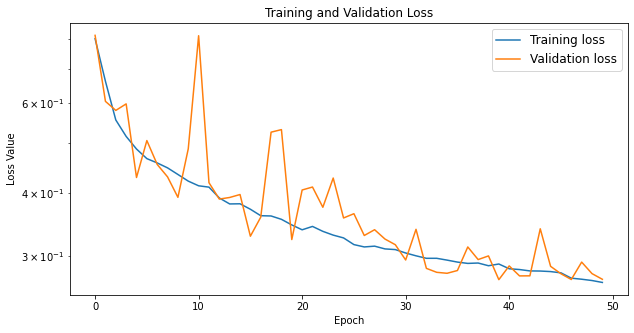

TRAINING FINISHED
Training time: 7606.6191029548645
Loss: [0.8021662831306458, 0.6617461442947388, 0.5556374192237854, 0.51582932472229, 0.48724091053009033, 0.46657392382621765, 0.4575575590133667, 0.4474569261074066, 0.43430760502815247, 0.4214383661746979, 0.4126366972923279, 0.41012948751449585, 0.3905163109302521, 0.3801431953907013, 0.3804115653038025, 0.3711405098438263, 0.3604567348957062, 0.36001288890838623, 0.35459402203559875, 0.34574609994888306, 0.3382093608379364, 0.343400239944458, 0.3358459770679474, 0.33017465472221375, 0.32602211833000183, 0.3163232207298279, 0.31299567222595215, 0.3141075074672699, 0.31022322177886963, 0.30927565693855286, 0.30454716086387634, 0.3006814122200012, 0.2973234951496124, 0.2973158061504364, 0.29489824175834656, 0.2922765016555786, 0.2905485928058624, 0.29104605317115784, 0.2874891757965088, 0.2897578775882721, 0.2836090624332428, 0.2826012670993805, 0.28083887696266174, 0.2806892991065979, 0.280009388923645, 0.27839940786361694, 0.271785

In [ ]:
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
csv_logger = CSVLogger('/content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/training_nogender-29-01.log', append=True)
callbacks = [checkpoint, reduce_lr, CustomCallback(), csv_logger]

incV3_nogender_history, incV3_nogender_time = fit_boneage(incV3_nogender, train_gen, train_steps, val_gen, val_steps,
                                                          epochs, callbacks, gender)
# actually I continued with 15 more episodes with these results:
# loss: 0.2513 - mae_in_months: 10.3500 - val_loss: 0.2900 - val_mae_in_months: 11.9447 - lr: 6.0000e-05 - train_time: 10209.7275

### Males only

In [26]:
# filtering new dataframes
train_df_M = train_df[train_df['gender(M/F)'] == 1]
validation_df_M = validation_df[validation_df['gender(M/F)'] == 1]
test_df_M = test_df[test_df['gender(M/F)'] == 1]

# number of steps between epochs
train_steps_M = int(np.ceil(train_df_M.shape[0] / batch_size))
val_steps_M = int(np.ceil(validation_df_M.shape[0] / batch_size))

print(train_df_M.shape[0], validation_df_M.shape[0], test_df_M.shape[0])

6833 773 100


In [35]:
# new generators
datagen_train_M = ImageDataGenerator(preprocessing_function=lambda x: x/255.,
                                   zoom_range=0.2, rotation_range=25, 
                                   width_shift_range=0.25, height_shift_range=0.25, 
                                   horizontal_flip=True, shear_range = 0.2)
datagen_val_M = ImageDataGenerator(preprocessing_function=lambda x: x/255., width_shift_range=0.25, 
                                 height_shift_range=0.25, horizontal_flip=True)
datagen_test_M = ImageDataGenerator(preprocessing_function=lambda x: x/255.)

train_gen_M = gen_2inputs(datagen_train_M, train_df_M, IMG_SIZE, batch_size, shuffle=True, seed=1)
val_gen_M = gen_2inputs(datagen_val_M, validation_df_M, IMG_SIZE, batch_size, shuffle=True, seed=1)
test_gen_M = gen_2inputs(datagen_test_M, test_df_M, IMG_SIZE, test_df_M.shape[0])

In [ ]:
model_name = 'incV3'
gender = False
incV3_M = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)

Found 6833 validated image filenames.
Found 6833 validated image filenames.
Epoch 1/50
214/214 [==============================] - ETA: 0s - loss: 0.9561 - mae_in_months: 39.3738 - accuracy: 0.0000e+00Found 773 validated image filenames.
Found 773 validated image filenames.

Epoch 1: val_loss improved from inf to 0.79677, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpoints/incV3-gender=Male-epochs=50_weights.best.hdf5
214/214 [==============================] - 108s 420ms/step - loss: 0.9561 - mae_in_months: 39.3738 - accuracy: 0.0000e+00 - val_loss: 0.7968 - val_mae_in_months: 32.8126 - val_accuracy: 0.0000e+00 - train_time: 108.4074
Epoch 2/50
214/214 [==============================] - ETA: 0s - loss: 0.7491 - mae_in_months: 30.8477 - accuracy: 0.0000e+00
Epoch 2: val_loss did not improve from 0.79677
214/214 [==============================] - 84s 394ms/step - loss: 0.7491 - mae_in_months: 30.8477 - accuracy: 0.0000e+00 - val_loss

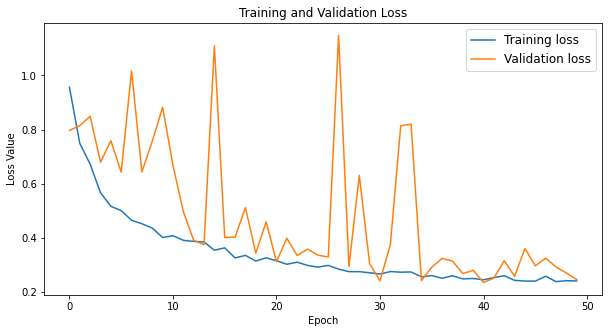

TypeError: ignored

<Figure size 720x360 with 0 Axes>

In [ ]:
weight_path = path + 'models_checkpoints/'+ "{}-gender={}-epochs={}_weights-29-01.best.hdf5".format(model_name, 'Male', epochs)
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
csv_logger = CSVLogger('/content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/training_Male-29-01.log', append=True)
callbacks = [checkpoint, reduce_lr, CustomCallback(), csv_logger]

incV3_M_history, incV3_M_time = fit_boneage(incV3_M, train_gen_M, train_steps_M, val_gen_M, val_steps_M,
                                            epochs, callbacks, 'Male')

### Females only

In [28]:
# filtering new dataframes
train_df_F = train_df[train_df['gender(M/F)'] == 0]
validation_df_F = validation_df[validation_df['gender(M/F)'] == 0]
test_df_F = test_df[test_df['gender(M/F)'] == 0]

# number of steps between epochs
train_steps_F = int(np.ceil(train_df_F.shape[0] / (batch_size/2)))
val_steps_F = int(np.ceil(validation_df_F.shape[0] / (batch_size/2)))

print(train_df_F.shape[0], validation_df_F.shape[0], test_df_F.shape[0])

5778 652 100


In [36]:
# new generators
datagen_train_F = ImageDataGenerator(preprocessing_function=lambda x: x/255.,
                                   zoom_range=0.2, rotation_range=25, 
                                   width_shift_range=0.25, height_shift_range=0.25, 
                                   horizontal_flip=True, shear_range = 0.2)
datagen_val_F = ImageDataGenerator(preprocessing_function=lambda x: x/255., width_shift_range=0.25, 
                                 height_shift_range=0.25, horizontal_flip=True)
datagen_test_F = ImageDataGenerator(preprocessing_function=lambda x: x/255.)

train_gen_F = gen_2inputs(datagen_train_F, train_df_F, IMG_SIZE, batch_size, shuffle=True, seed=1)
val_gen_F = gen_2inputs(datagen_val_F, validation_df_F, IMG_SIZE, batch_size, shuffle=True, seed=1)
test_gen_F = gen_2inputs(datagen_test_F, test_df_F, IMG_SIZE, test_df_F.shape[0])

In [ ]:
model_name = 'incV3'
gender = False
optim = tf.keras.optimizers.Adam(learning_rate=0.0001)
incV3_F = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', optim, mae_in_months, with_gender=gender)

In [ ]:
weight_path = path + 'models_checkpoints/'+ "{}-gender={}-epochs={}_weights-30-01.best.hdf5".format(model_name, 'Female', epochs)
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
csv_logger = CSVLogger('/content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/training_Female-30-01.log', append=True)
callbacks = [checkpoint, reduce_lr, CustomCallback(), csv_logger]

incV3_F_history, incV3_F_time = fit_boneage(incV3_F, train_gen_F, None, val_gen_F, None,
                                            epochs, callbacks, 'Female')

## Model evaluation

In [ ]:
model_name = 'incV3'
gender = True

weight_path = path + 'models_checkpoints/'+ "{}_weights.best.hdf5".format(model_name)
model = create_model(model_name, (IMG_SIZE, IMG_SIZE, 1), 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)
model.load_weights(weight_path)

In [ ]:
test_X, test_Y = next(test_gen)
pred_Y = std_bone_age * model.predict(test_X, batch_size = batch_size, verbose = True) + mean_bone_age
test_Y_months = std_bone_age * test_Y + mean_bone_age

Found 200 validated image filenames.
Found 200 validated image filenames.
7/7 [==============================] - 43s 5s/step


Text(0, 0.5, 'Predicted Age (Months)')

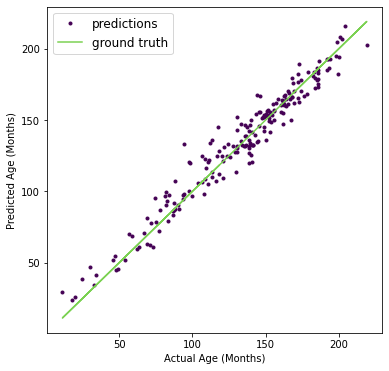

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (6,6))
ax.plot(test_Y_months, pred_Y, '.', c=colors[0], label = 'predictions')
ax.plot(test_Y_months, test_Y_months, '-', c=colors[-1], label = 'ground truth')
ax.legend()
ax.set_xlabel('Actual Age (Months)')
ax.set_ylabel('Predicted Age (Months)')

In [ ]:
# Evaluate the model
loss, mae = model.evaluate(test_gen, verbose=2, steps=1)

1/1 - 25s - loss: 0.1731 - mae_in_months: 7.1292 - 25s/epoch - 25s/step


In [ ]:
miss = np.abs(pred_Y.T - test_Y_months)
print('Max error: {}'.format(np.max(miss)))
print('Mean error: {}'.format(np.mean(miss)))
print('Median error: {}'.format(np.median(miss)))

Max error: 38.744114254960934
Mean error: 7.129198855942281
Median error: 5.291819109009467


Visualize predictions

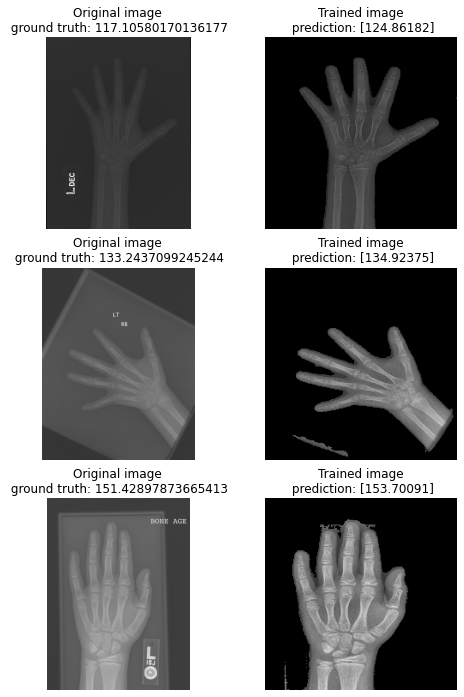

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(8, 12))
[ax.axis('off') for ax in axs.flatten()]

indexes = np.random.randint(0, test_df.shape[0], size=3)
for i, ax in enumerate(axs):
  ind = indexes[i]
  name = test_df.loc[ind, 'image'].split('/')[-1]
  original = cv2.imread(test_path + 'Test Set Images/' + name)
  # original = cv2.imread(test_path + 'Test Set Images Contrast/' + name)
  masked = cv2.imread(test_df.loc[ind, 'image'])

  ax[0].imshow(original)
  ax[1].imshow(masked)
  ax[0].set_title('Original image\n ground truth: {}'.format(test_Y_months[ind]))
  ax[1].set_title('Trained image\n prediction: {}'.format(pred_Y[ind]))

### R2 score

R2 indicates the proportion of data points which lie within the line created by the regression equation. A higher value of R2 is desirable as it indicates better results.

R2= 1- SSres / SStot

In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(test_Y_months, pred_Y)
r2

0.9513570384481993

## Model comparison

In [37]:
from sklearn.metrics import r2_score

def load_model_data(model_name, weight_path, logs_path, t_gen, gender=True):
  # create and load model's best version
  model = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)
  model.load_weights(path + 'models_checkpoints/' + weight_path)
  # load training data
  logs = pd.read_csv(path + logs_path)
  # model params
  params = model.count_params()
  # evaluate model (loss, mae)
  # test_eval = model.evaluate(t_gen, verbose=0, steps=1)
  test_eval = model.evaluate(t_gen, verbose=1, steps=1)
  
  # compute predictions
  input, g_truth = next(t_gen)
  # pred = std_bone_age * model.predict(input, batch_size = batch_size, verbose=True) + mean_bone_age
  pred = std_bone_age * model.predict(input, batch_size = batch_size, verbose=False) + mean_bone_age
  g_truth = std_bone_age * g_truth + mean_bone_age
  # R2 score
  r2 = r2_score(g_truth, pred)

  return model, logs, params, test_eval, r2

In [38]:
incV3, incV3_logs, incV3_params, incV3_test, incV3_r2 = load_model_data('incV3', "{}-28-01_weights.best.hdf5".format('incV3'), 
                                                                        'training_incV3_28-01.log', test_gen)
incV3nog, incV3nog_logs, incV3nog_params, incV3nog_test, incV3nog_r2 = load_model_data('incV3', "{}-29-01-gender={}-epochs={}_weights.best.hdf5".format('incV3', False, epochs), 
                                                     'training_nogender-29-01.log', test_gen, gender=False)
incV3M, incV3M_logs, incV3M_params, incV3M_test, incV3M_r2 = load_model_data('incV3', "{}-gender={}-epochs={}_weights-29-01.best.hdf5".format('incV3', 'Male', epochs), 
                                                     'training_Male-29-01.log', test_gen_M, gender=False)
incV3F, incV3F_logs, incV3F_params, incV3F_test, incV3F_r2 = load_model_data('incV3', "{}-gender={}-epochs={}_weights.best.hdf5".format('incV3', 'Female', epochs), 
                                                     'training_Female.log', test_gen_F, gender=False)
incV4, incV4_logs, incV4_params, incV4_test, incV4_r2 = load_model_data('incV4', "{}_weights.best.hdf5".format('incV4'),
                                                  'training_incV4.log', test_gen)
vgg16, vgg16_logs, vgg16_params, vgg16_test, vgg16_r2 = load_model_data('vgg16', "vgg16-30-01_weights.best.hdf5",
                                                  'training_VGG16_09-02.log', test_gen)
# resnet, resnet_logs, resnet_params, resnet_test, resnet_r2 = load_model_data('resnet50', "{}_weights_01-02.best.hdf5".format('resnet50'),
#                                                   'training_resnet_01-02.log', test_gen)
incres, incres_logs, incres_params, incres_test, incres_r2 = load_model_data('incRes', "incRes_weights_08-02.best.hdf5",
                                                  'training_incRes_08-02.log', test_gen)

Found 200 validated image filenames.
Found 200 validated image filenames.


7/7 [==============================] - 26s 4s/step
Found 100 validated image filenames.
Found 100 validated image filenames.
4/4 [==============================] - 15s 3s/step
Found 100 validated image filenames.
Found 100 validated image filenames.
7/7 [==============================] - 52s 7s/step


ValueError: ignored

In [46]:
# changing matplotlib.pyplot style
plt.style.use('ggplot') # R like
# plt.style.use('bmh')
# plt.style.use('fivethirtyeight')
# plt.style.use('default')

In [45]:
models = ['incV3', 'incV3 nogender', 'incV3 Male', 'incV3 Female', 'incV4', 'vgg16', 'incRes']

def plot_bars(values, color, title, xlabel, ylabel, values_2=None, values_3=None, annotate=True):
  x_pos = np.arange(len(models))
  
  if values_3:
    fig, ax = plt.subplots(figsize=(10, 5))
    # plot data in grouped manner of bar type
    plt.bar(x_pos-0.3, values, 0.2, color=colors[0])
    plt.bar(x_pos, values_2, 0.2, color=colors[int(len(colors)/2)])
    plt.bar(x_pos+0.3, values_3, 0.2, color=colors[-1])
    plt.legend(['train', 'validation', 'test'])
  elif values_2:
    fig, ax = plt.subplots(figsize=(8, 5))
    # plot data in grouped manner of bar type
    plt.bar(x_pos-0.2, values, 0.4, color=colors[1])
    plt.bar(x_pos+0.2, values_2, 0.4, color=colors[3])
    plt.legend(['train', 'validation'])
  else:
    fig, ax = plt.subplots(figsize=(8, 5))
    plots = plt.bar(x_pos, values, color=colors)
    if annotate:
      for i in range(len(models)):
        plt.annotate(int(values[i]), (x_pos[i], values[i]), ha='center', va='center',
                    size=10, xytext=(0,5), textcoords='offset points')

  plt.xticks(x_pos, models)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

We should take the best results of the model, which corresponds to the ones where the val_loss is the lowest.

In [47]:
ind = [np.argmin(incV3_logs['val_loss']), np.argmin(incV3nog_logs['val_loss']), np.argmin(incV3M_logs['val_loss']),
       np.argmin(incV3F_logs['val_loss']), np.argmin(incV4_logs['val_loss']), np.argmin(vgg16_logs['val_loss']),
       np.argmin(incres_logs['val_loss'])]

Plot #parameters

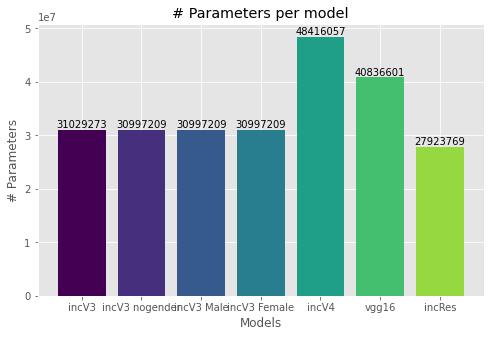

In [48]:
num_params = [incV3_params, incV3nog_params, incV3M_params, incV3F_params, incV4_params, vgg16_params, incres_params]
# create an annotation over the bars with the actual values

plot_bars(num_params, colors, '# Parameters per model', 'Models', '# Parameters')

Plot training time

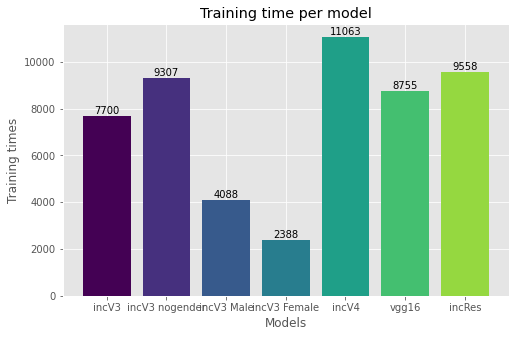

In [49]:
tr_times = [list(incV3_logs['train_time'])[ind[0]], list(incV3nog_logs['train_time'])[ind[1]], list(incV3M_logs['train_time'])[ind[2]],
            list(incV3F_logs['train_time'])[ind[3]], list(incV4_logs['train_time'])[ind[4]], list(vgg16_logs['train_time'])[ind[5]], 
            list(incres_logs['train_time'])[ind[6]]]

plot_bars(tr_times, colors, 'Training time per model', 'Models', 'Training times')

Plot accuracy/loss

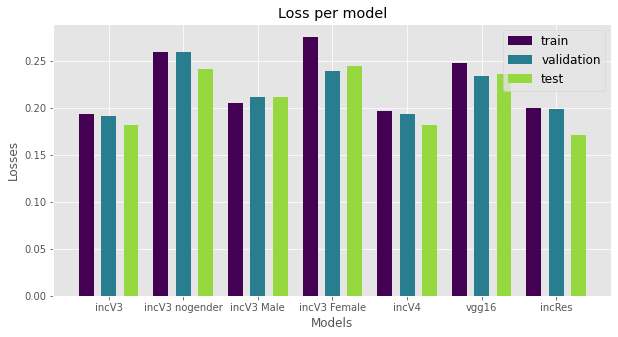

In [50]:
losses = [list(incV3_logs['loss'])[ind[0]], list(incV3nog_logs['loss'])[ind[1]], list(incV3M_logs['loss'])[ind[2]], 
          list(incV3F_logs['loss'])[ind[3]], list(incV4_logs['loss'])[ind[4]], list(vgg16_logs['loss'])[ind[5]],
          list(incres_logs['loss'])[ind[6]]]
val_losses = [list(incV3_logs['val_loss'])[ind[0]], list(incV3nog_logs['val_loss'])[ind[1]], list(incV3M_logs['val_loss'])[ind[2]], 
          list(incV3F_logs['val_loss'])[ind[3]], list(incV4_logs['val_loss'])[ind[4]], list(vgg16_logs['val_loss'])[ind[5]], 
          list(incres_logs['val_loss'])[ind[6]]]
test_losses = [incV3_test[0], incV3nog_test[0], incV3M_test[0], incV3F_test[0], incV4_test[0], vgg16_test[0], incres_test[0]]

plot_bars(losses, colors, 'Loss per model', 'Models', 'Losses', val_losses, test_losses)

We can also see how does it change the graph when Male and Female models are evaluated with all test dataset

In [ ]:
# test_eval_M = incV3M.evaluate(test_gen, verbose=0, steps=1)
# test_eval_F = incV3F.evaluate(test_gen, verbose=0, steps=1)

In [ ]:
# test_losses2 = [incV3_test[0], test_eval_M[0], test_eval_F[0], incV4_test[0]]

# plot_bars(losses, colors, 'Loss per model', 'Models', 'Losses', val_losses, test_losses2)

Plot MAE

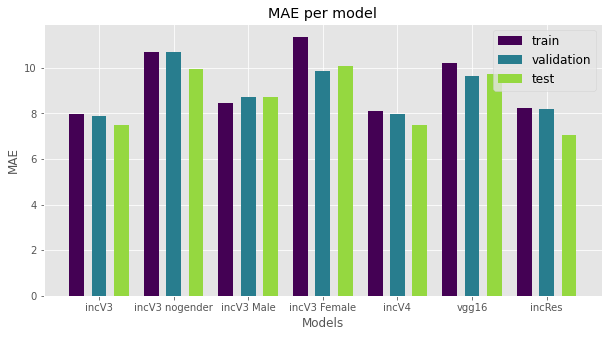

In [51]:
maes = [list(incV3_logs['mae_in_months'])[ind[0]], list(incV3nog_logs['mae_in_months'])[ind[1]], list(incV3M_logs['mae_in_months'])[ind[2]], 
        list(incV3F_logs['mae_in_months'])[ind[3]], list(incV4_logs['mae_in_months'])[ind[4]], list(vgg16_logs['mae_in_months'])[ind[5]], 
        list(incres_logs['mae_in_months'])[ind[6]]]
val_maes = [list(incV3_logs['val_mae_in_months'])[ind[0]], list(incV3nog_logs['val_mae_in_months'])[ind[1]], list(incV3M_logs['val_mae_in_months'])[ind[2]], 
            list(incV3F_logs['val_mae_in_months'])[ind[3]], list(incV4_logs['val_mae_in_months'])[ind[4]], list(vgg16_logs['val_mae_in_months'])[ind[5]], 
            list(incres_logs['val_mae_in_months'])[ind[6]]]
test_maes = [incV3_test[1], incV3nog_test[1], incV3M_test[1], incV3F_test[1], incV4_test[1], vgg16_test[1], incres_test[1]]

plot_bars(maes, colors, 'MAE per model', 'Models', 'MAE', val_maes, test_maes)

Plot R2 score

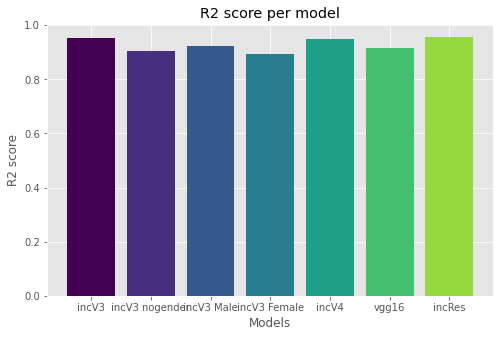

R2 SCORES

InceptionV3: 0.953748411317443
InceptionV3-nogender: 0.9054320234316122
InceptionV3-Male: 0.9245010968720156
InceptionV3-Female: 0.8928946134006515
InceptionV4: 0.9473506928578381
VGG16: 0.9170804145275396
ResNet50: 0.9566014810580635


In [52]:
r2s = [incV3_r2, incV3nog_r2, incV3M_r2, incV3F_r2, incV4_r2, vgg16_r2, incres_r2]
# add annotations

plot_bars(r2s, colors, 'R2 score per model', 'Models', 'R2 score', annotate=False)

print('R2 SCORES\n')
print('Inception-v3: {}'.format(r2s[0]))
print('Inception-v3-nogender: {}'.format(r2s[1]))
print('Inception-v3-Male: {}'.format(r2s[2]))
print('Inception-v3-Female: {}'.format(r2s[3]))
print('Inception-v4: {}'.format(r2s[4]))
print('VGG16: {}'.format(r2s[5]))
print('Inception-ResNet: {}'.format(r2s[6]))

Training loss flow

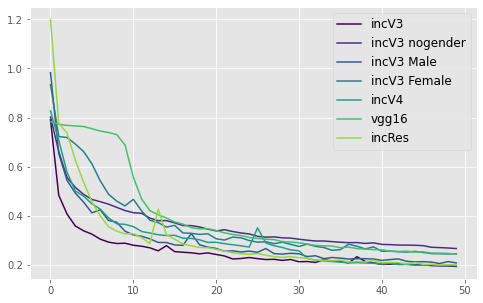

In [58]:
fig, ax = plt.subplots(figsize=(8, 5))

plt.plot(np.array(incV3_logs['loss']), label='incV3', c=colors[0])
plt.plot(np.array(incV3nog_logs['loss'][:50]), label='incV3 nogender', c=colors[1])
plt.plot(np.array(incV3M_logs['loss']), label='incV3 Male', c=colors[2])
plt.plot(np.array(incV3F_logs['loss']), label='incV3 Female', c=colors[3])
plt.plot(np.array(incV4_logs['loss']), label='incV4', c=colors[4])
plt.plot(np.array(vgg16_logs['loss']), label='vgg16', c=colors[5])
# plt.plot(np.array(incres_logs['loss']), label='incRes', c=colors[6])
incres_loss = incres_logs['loss'].copy()
incres_loss[0] = 1.2
plt.plot(np.array(incres_loss), label='incRes', c=colors[6])
plt.legend()
plt.show()

An interesting result is to study how the evaluation changes whenever the test set is not touched (i.e. no contrast enhancement and no masks)

In [ ]:
!cp -r '/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/data/Bone Age Test Set/Test Set Images' 'Test Set Images'

In [ ]:
test_df_raw = test_df.copy()
test_df_raw['image'] = test_df_raw['image'].apply(lambda p: 'Test Set Images/' + p.split('/')[-1])

datagen_test_raw = ImageDataGenerator(preprocessing_function=lambda x: x/255.)
test_gen_raw = gen_2inputs(datagen_test_raw, test_df_raw, IMG_SIZE, test_df_raw.shape[0])

In [ ]:
# evaluate model (loss, mae)
test_eval_raw = incV3.evaluate(test_gen_raw, verbose=0, steps=1)

# compute predictions
input, g_truth = next(test_gen_raw)
pred = std_bone_age * incV3.predict(input, batch_size = batch_size, verbose=True) + mean_bone_age
g_truth = std_bone_age * g_truth + mean_bone_age
# R2 score
r2_raw = r2_score(g_truth, pred)

7/7 [==============================] - 25s 3s/step


In [ ]:
print("MODIFIED DATA")
print("Test Loss: {}\nMAE: {}\nR2: {}\n".format(incV3_test[0], incV3_test[1], incV3_r2))
print("RAW DATA")
print("Test Loss: {}\nMAE: {}\nR2: {}".format(test_eval_raw[0], test_eval_raw[1], r2_raw))

MODIFIED DATA
Test Loss: 0.18177548050880432
MAE: 7.485881328582764
R2: 0.953748411317443

RAW DATA
Test Loss: 0.362721711397171
MAE: 14.937614440917969
R2: 0.774455698483969


Bubbles

In [67]:
def plot_bubbles(models, x, y, z, xlabel, ylabel):
  fig, _ = plt.subplots(figsize=(8, 5))
  plt.scatter(x = x, y = y, s=z/10000, c=colors, 
              alpha=0.6, edgecolors="white", linewidth=2)
  
  plt.xlim(1500, 12500)
  plt.ylim(0.1, 0.33)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  for i, txt in enumerate(models):
    plt.annotate(txt, (x[i], y[i]), ha='center', va='center',
                 size=10, xytext=(0,0), textcoords='offset points')
  plt.show()

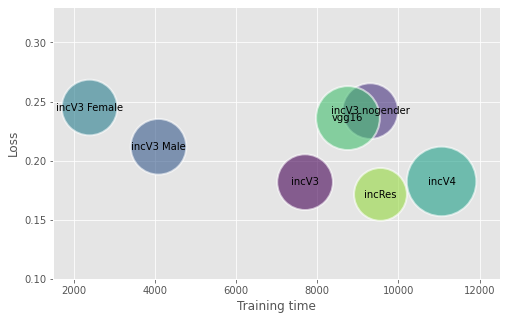

In [68]:
# models = ['incV3', 'incV3 nogender', 'incV3 Male', 'incV3 Female', 'incV4', 'vgg16', 'resnet']
plot_bubbles(models, np.array(tr_times), np.array(test_losses), np.array(num_params), 'Training time', 'Loss')

Save all the data in a csv

In [69]:
df = pd.DataFrame()
df['model'] = models
df['loss'] = losses
df['mae'] = maes
df['val_loss'] = val_losses
df['val_mae'] = val_maes
df['test_loss'] = test_losses
df['test_mae'] = test_maes
df['train time'] = tr_times
df['eval time'] = [25, 27, 15, 14, 57, 126, 41]
df['parameters'] = num_params
df['R2 score'] = r2s
df['layers'] = [len(incV3.layers), len(incV3nog.layers), len(incV3M.layers), len(incV3F.layers), 
                len(incV4.layers), len(vgg16.layers), len(incres.layers)]
df

,model,loss,mae,val_loss,val_mae,test_loss,test_mae,train time,eval time,parameters,R2 score,layers
0,incV3,0.193734,7.978377,0.191199,7.873982,0.181775,7.485881,7700.287749,25,31029273,0.953748,319
1,incV3 nogender,0.259239,10.675970,0.259852,10.701235,0.241909,9.962301,9307.127729,27,30997209,0.905432,317
2,incV3 Male,0.205651,8.469117,0.212047,8.732509,0.211730,8.719486,4088.409592,15,30997209,0.924501,317
3,incV3 Female,0.275624,11.350770,0.239426,9.860029,0.244941,10.087188,2388.575385,14,30997209,0.892895,317
4,incV4,0.196511,8.092702,0.193336,7.961967,0.182387,7.511067,11063.618063,57,48416057,0.947351,493
5,vgg16,0.247769,10.203614,0.234323,9.649901,0.236005,9.719163,8755.461540,126,40836601,0.917080,26
6,incRes,0.199889,8.231850,0.198435,8.171944,0.171430,7.059849,9558.659784,41,27923769,0.956601,346


In [70]:
df.to_csv(path+'boneage_models_data_10-02.csv')

## Saliency Maps

In [ ]:
model = create_model('incV3', IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=True)
model.load_weights(path + "models_checkpoints/incV3-28-01_weights.best.hdf5")

In [71]:
sample = next(test_gen)

In [73]:
# p = model.predict(sample[0], batch_size = batch_size, verbose=True)
p = incres.predict(sample[0], batch_size = batch_size, verbose=True)

7/7 [==============================] - 35s 5s/step


In [74]:
i = abs(p.T - sample[1]).argmin()

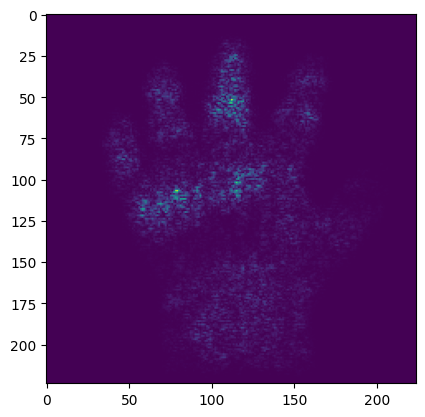

In [77]:
plt.style.use('default')

# Define the image and the single value inputs
img = sample[0][0][i]
val = sample[0][1][i]
y = sample[1][i]

img = tf.convert_to_tensor(img)
val = tf.convert_to_tensor(val, dtype=tf.float32)
img = tf.expand_dims(img, axis=0)
val = tf.expand_dims(val, axis=0)

# Define the loss function
loss = mae_in_months

# Use GradientTape to record the forward pass
with tf.GradientTape() as tape:
    tape.watch([img, val])
    # logits = model([img, val])
    logits = incres([img, val])
    current_loss = loss(logits, y)

# Compute the gradients with respect to the image input
saliency = tape.gradient(current_loss, img)

# # Generate the saliency map
saliency_map = tf.math.abs(tf.math.reduce_mean(saliency, axis=0))
saliency_map = tf.math.l2_normalize(saliency_map)

# # Plot the saliency map
plt.imshow(tf.squeeze(saliency_map))
plt.show()

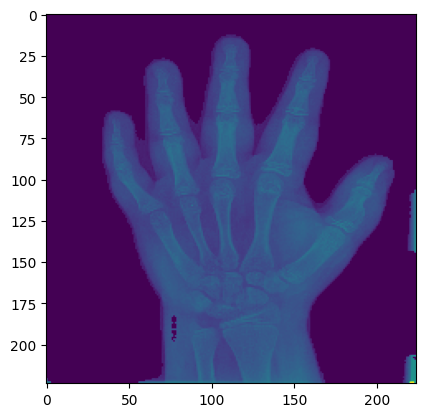

In [78]:
plt.imshow(tf.squeeze(img))